In [1]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
import numpy as np
import re, string, random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
#!pip install hvplot
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Mounted at /content/drive


In [2]:
nltk.download('stopwords')
#nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('all')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_da

True

In [3]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


In [4]:
Name = "META"
stocks_df = pd.read_csv('/content/drive/MyDrive/stock_price_prediction/'+Name+'(stockdata).csv')
tweets_df = pd.read_csv('/content/drive/MyDrive/stock_price_prediction/'+Name+'2022.csv', dtype="string", encoding='latin1')

In [5]:
stocks_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-01,228.500000,239.000000,227.559998,237.550003,237.550003,43399700
1,2020-07-02,239.000000,240.000000,232.610001,233.419998,233.419998,30633600
2,2020-07-06,233.759995,240.399994,232.270004,240.279999,240.279999,26206200
3,2020-07-07,239.410004,247.649994,238.820007,240.860001,240.860001,27887800
4,2020-07-08,238.110001,246.990005,236.589996,243.580002,243.580002,29791300
...,...,...,...,...,...,...,...
499,2022-06-24,161.729996,170.250000,161.300003,170.160004,170.160004,68736000
500,2022-06-27,171.320007,171.750000,168.009995,169.490005,169.490005,29174600
501,2022-06-28,169.899994,171.300003,160.610001,160.679993,160.679993,27744500
502,2022-06-29,163.570007,166.330002,160.320007,163.940002,163.940002,28595200


In [6]:
col1 = tweets_df.columns[0]
tweets_df.rename(columns={col1:'Date'}, inplace=True)

In [7]:
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [8]:
tweets_df

,Date,0,1,2,3,4,5,6,7,8,...,184,185,186,187,188,189,190,191,192,193
0,2020-07-03,@yvngreaper14 @EASPORTSFIFA If saint max wins ...,@Guillermo76484 @SethAbramson @TheRickWilson M...,OjalÃ¡ algÃºn dÃ­a @SoyHugoOT2020 se meta en e...,"Entre pegar um bebÃª e um anÃ£o no colo, eu pe...",ð´Estamos aquÃ­ para acompaÃ±arlos a desarro...,"sim, eu baixei um jogo e to evoluindo as coisa...",@nanogenomic The meta-analysis cited above had...,@GPNoContext Well SMG4âs fanbase is pretty d...,"Meta is so dogshit. Only third parties, Maraud...",...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2020-07-04,Minha meta pra agora Ã© atualizar tudo que tem...,@NA2ARENO Jajaja acÃ¡ Naza adhieren que meta c...,Y por favor no se les olvide que hoy estamos c...,"Meta cumplida, hablar con tu ahora, amor impos...",ð Favela venceu familhiiiaa! - !SunfireRP ð...,@latinus_us Pues que cuide lo que dice y que n...,meta isso no seu perfil e veja quantas pessoas...,LATEST ADDITIONS: An Evaluation of the Nutriti...,La industria del petrÃ³leo y gas continÃºa apo...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2020-07-05,"@G2BarbeQ el mejor rapero de la historia, porf...",Deria estar orgulloso segun mis amigos pero si...,ReportÃ¡ndome a la #ARMYStreamBattle_D1 con el...,@khale_esi96 Sono ad inizio quinto episodio e ...,gente essa build de ahri tÃ¡ no meta??? https...,@_saturnsz_ meta pra mim eh isso,@CarlaZambelli38 @Defensoriasp Deputada marca ...,Lembro que minha meta pessoal era terminar e d...,@nonsensetuits no se llegÃ³ a la meta :( ya va...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2020-07-06,@Damihibibere Muy bueno el hilo y el mensaje q...,"@joseq311 @MA_palaC Una nueva meta, tengo que ...",@IndianaOhmz @BenjaminGladst1 @GerbusJames @do...,ð¤£ð¤£ð¤£ððð,@Joaoopospich Meta os dreads,@APL_Fear What even is the meta lol I haven't ...,@Andrew_east @nick_dav_ @BrenCasts @hexagrams ...,meta,"@b3ckYm4rt1ns AMG MKkkkkkmk eu todo, esse vÃ­d...",...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2020-07-08,Disjointed veer back to upgrades: Each mech ha...,Mi meta es llegar al punto que me critiquen po...,@Andrrewwwwwwww Ø§ÙÙ meta analysis ÙÙ Ø¯Ø±...,"@qorygore gausah make kalung anti corona,kita ...",meta isso no seu perfil e veja quantas pessoas...,@Pedrorrez Meta Ã© essa,Minha meta de vida Ã© viver dentro de um ambie...,@unm4sk_pt2 PrÃ³xima mesa minha meta vai ser t...,As necessidades humanas fundamentais podem ser...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2022-06-20,@cabralzinmh @psci_ @Botafogo conta pra mim qu...,@Otherside_Meta loser scam,meu deus...eu deveria estar fazendo meta de le...,"@ido_meta Dear sir, many people want to buy wa...",@LaPosta_Ecu La sentencia es para que @LaPosta...,@josealcaide222 @Salvadormoheda2 Mucho le sopo...,"@MaElviraSalazar Respete al pueblo colombiano,...",Vamos bater a meta aqui pessoal,A meta da minha vida Ã© ter a evoluÃ§Ã£o menta...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
376,2022-06-24,@st3f4ny_ MINHA META SER ASSIM,@Jaci_DAO we still on degen mint meta ser @Min...,@robocell @techgirl1908 I hope it does. Thread...,@meta_arabic ÙØ§Ø²ÙÙÙ,@pitchulinhaline Ã a meta,@ErikaEscalanteL Todo mundo deberÃ­a tener esa...,En #Cuba lograr avanzar en el empoderamiento f...,"@sedyyx @canaltech Essa Ã© a meta, mesmo bloqu...",@diputadonaranjo O meta a los pitutos !! http...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
377,2022-06-25,@Ziilverk @LuzuGames Espera que no le meta uno...,@DaJenus @thetokensite @banana_ballers @Wonder...,@firel0w Meta,@Guilher23599093 @hiroxzfn @yDiamondd Simplici...,@ominpo_popo ã½ããã®ä¸ã®é¨åãªãèª...,@carlosoporto No sirviÃ³ de nada ser sensibles...,"Ir atormentar ele amanhÃ£, serÃ¡ a minha meta",@Rafael_delRosal @lokopeda @mablanco60 @Makaki...,@BasadoTrolso @last_try_josele Puuufff.... Dra...,...,<NA>,<NA>,<

In [9]:
#drop days from tweets df that are on weekends and holidays because the stock market is only open on weekdays
tweets_dropped1 = pd.merge(stocks_df["Date"], tweets_df, on="Date")

In [10]:
#drop days from tweets df that are on weekends and holidays because the stock market is only open on weekdays
tweets_dropped = pd.merge(stocks_df["Date"], tweets_df, on="Date").drop(columns=["Date"])

In [11]:
tweets_dropped.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,@Damihibibere Muy bueno el hilo y el mensaje q...,"@joseq311 @MA_palaC Una nueva meta, tengo que ...",@IndianaOhmz @BenjaminGladst1 @GerbusJames @do...,ð¤£ð¤£ð¤£ððð,@Joaoopospich Meta os dreads,@APL_Fear What even is the meta lol I haven't ...,@Andrew_east @nick_dav_ @BrenCasts @hexagrams ...,meta,"@b3ckYm4rt1ns AMG MKkkkkkmk eu todo, esse vÃ­d...",We had one year long meta last year and this w...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Disjointed veer back to upgrades: Each mech ha...,Mi meta es llegar al punto que me critiquen po...,@Andrrewwwwwwww Ø§ÙÙ meta analysis ÙÙ Ø¯Ø±...,"@qorygore gausah make kalung anti corona,kita ...",meta isso no seu perfil e veja quantas pessoas...,@Pedrorrez Meta Ã© essa,Minha meta de vida Ã© viver dentro de um ambie...,@unm4sk_pt2 PrÃ³xima mesa minha meta vai ser t...,As necessidades humanas fundamentais podem ser...,Armando Rojas Guardia fue hospitalizado hoy de...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Sweeps x The Meta Team: ASUS 165Hz Gaming Moni...,@Blazt Octane was doing this with the Grau ear...,a meta Ã© chegar em guriri p trocar as tranÃ§a...,Quando o seu coraÃ§Ã£o estiver apertado diante...,@falloutplays @Ms5000Watts We have seen pulse ...,i remember 14 yo me wanting to find Elsa meta ...,@meta_knightt I hugged him back and rubbed his...,minha meta Ã© esse ryzen 5 3600x e uma RTX 2060,the ember island players episode will always b...,@FabianHallsten @INTERRO I don't see an issue ...,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,@RyanJMonaco1 @Safarooniee Probably best playe...,two ppl down at 5 cyphers against spider see w...,@ElenaGarzaM El riesgo radica en la susceptibi...,sÃ© que quieres que te meta a mi mundo pero no,@ViejitodellHoyo Se que los sueÃ±os no se cump...,Minha meta de vida https://t.co/j8dTPoRH4c,META BATIDA! ð #TeamShadow SHADOW STAR @BT...,@artangxls Faz propaganda mana nÃ£o se poupa v...,@SokingRcQ Hay que aprender a jugar de todo pa...,@SIN24Horas Dios que meta su mano,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,"I think I need to reset my stats, life is gett...","@FatherFigment Roman tilted his head, confused...",@agsampaio Que show!!! Agora estou no cabide p...,@PPIIEETTRRA Minha meta Ã© ter,"@jungeunqr YO LE DIGO SOY HOMBRE TENGO VERGA, ...",@PortalTatto @NickelodeonBR meta BIBI NO MPN,@melissadosanjos Teu pai Ã© minha meta de adulto,@Indignara La meta del gobierno @IvanDuque no ...,@loey_fi se olvidaron la meta de views para la...,Minha meta Ã© ficar rico esse ano ! ð,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [12]:
#process tweets into sentiment values for a given day
tweets_tokenized = tweets_dropped.applymap(lambda x: word_tokenize(x) if not pd.isnull(x) else x)
tweets_noiseless = tweets_tokenized.applymap(lambda y: remove_noise(y) if not pd.isnull([y]).any() else y)

In [13]:
#tweets_noiseless = pd.DataFrame(tweets_noiseless)
tweets_noiseless

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,"[damihibibere, muy, bueno, el, hilo, y, el, me...","[joseq311, ma_palac, una, nueva, meta, tengo, ...","[indianaohmz, benjamingladst1, gerbusjames, do...",[ð¤£ð¤£ð¤£ððð],"[joaoopospich, meta, os, dread]","[apl_fear, what, even, be, the, meta, lol, i, ...","[andrew_east, nick_dav_, brencasts, hexagram, ...",[meta],"[b3ckym4rt1ns, amg, mkkkkkkmk, eu, todo, esse,...","[we, have, one, year, long, meta, last, year, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[disjointed, veer, back, to, upgrade, each, me...","[mi, meta, e, llegar, al, punto, que, me, crit...","[andrrewwwwwwww, ø§ùù, meta, analysis, ùù,...","[qorygore, gausah, make, kalung, anti, corona,...","[meta, isso, no, seu, perfil, e, veja, quantas...","[pedrorrez, meta, ã©, essa]","[minha, meta, de, vida, ã©, viver, dentro, de,...","[unm4sk_pt2, prã³xima, mesa, minha, meta, vai,...","[as, necessidades, humanas, fundamentais, pode...","[armando, rojas, guardia, fue, hospitalizado, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[sweeps, x, the, meta, team, asus, 165hz, gami...","[blazt, octane, be, do, this, with, the, grau,...","[a, meta, ã©, chegar, em, guriri, p, trocar, a...","[quando, o, seu, coraã§ã£o, estiver, apertado,...","[falloutplays, ms5000watts, we, have, see, pul...","[i, remember, 14, yo, me, want, to, find, elsa...","[meta_knightt, i, hug, him, back, and, rub, hi...","[minha, meta, ã©, esse, ryzen, 5, 3600x, e, um...","[the, ember, island, player, episode, will, al...","[fabianhallsten, interro, i, do, n't, see, an,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[ryanjmonaco1, safarooniee, probably, best, pl...","[two, ppl, down, at, 5, cypher, against, spide...","[elenagarzam, el, riesgo, radica, en, la, susc...","[sã©, que, quieres, que, te, meta, a, mi, mund...","[viejitodellhoyo, se, que, los, sueã±os, no, s...","[minha, meta, de, vida, http, //t.co/j8dtporh4c]","[meta, batida, ð, teamshadow, shadow, star,...","[artangxls, faz, propaganda, mana, nã£o, se, p...","[sokingrcq, hay, que, aprender, a, jugar, de, ...","[sin24horas, dios, que, meta, su, mano]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[i, think, i, need, to, reset, my, stats, life...","[fatherfigment, roman, tilt, his, head, confus...","[agsampaio, que, show, agora, estou, no, cabid...","[ppiieettrra, minha, meta, ã©, ter]","[jungeunqr, yo, le, digo, soy, hombre, tengo, ...","[portaltatto, nickelodeonbr, meta, bibi, no, mpn]","[melissadosanjos, teu, pai, ã©, minha, meta, d...","[indignara, la, meta, del, gobierno, ivanduque...","[loey_fi, se, olvidaron, la, meta, de, views, ...","[minha, meta, ã©, ficar, rico, esse, ano, ð]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,"[a, meta, de, ir, no, rap, in, cena, vai, fica...","[nunca, bata, meta, se, nã£o, eles, dobram, a,...","[lvsshinee, es, una, pelotuda, si, le, sirven,...","[xpattonsworld, imagineif, they, build, them, ...","[johnmiltonr_, no, se, meta, con, la, niã±a, b...","[planetaboca, luisadvincula17, asã­, de, depri...","[for, some, reason, when, i, be, post, this, f...","[a, meta, ã©, ficar, gostosa, tal, qual, bruna...","[fpx_meta, fpx_esports, fpxæ¯æä¸ç´éå¸¸å...","[theophite, mffwww, the, study, on, post, acut...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,"[team, ``, s/nombre, '', team, recuerden, que,...","[desbordes, no, se, meta, usted, por, favor, m...","[metanetwork, ã¡ã¿ãã¼ã¹ä¸ã, «, ã¨ã³ã...","[15/6, 20:59, samarao, novo, ð§¡, acho, q, eh...","[meta_games_lab, sri_afriyanti, diva_rianto, t...","[agriculturafm, fenran, que, se, meta, el, map...","[meta, f1, token, be, a, game, metaverse, base...","[lenadolll, wan, na, run, up, into, the, meta,...","[meta, f1, token, be, a, game, metaverse, base...","[top, story, meta, adds, new, parental, contro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,"[st3f4ny_, mi

In [14]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
twd =TreebankWordDetokenizer()

In [15]:
reconstructedSentence = tweets_noiseless.applymap(lambda z: twd.detokenize(z) if not pd.isnull([z]).any() else z)

In [16]:
reconstructedSentence

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,damihibibere muy bueno el hilo y el mensaje qu...,joseq311 ma_palac una nueva meta tengo que ir ...,indianaohmz benjamingladst1 gerbusjames doctor...,ð¤£ð¤£ð¤£ððð,joaoopospich meta os dread,apl_fear what even be the meta lol i haven't b...,andrew_east nick_dav_ brencasts hexagram and i...,meta,b3ckym4rt1ns amg mkkkkkkmk eu todo esse vã­deo...,we have one year long meta last year and this ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,disjointed veer back to upgrade each mech have...,mi meta e llegar al punto que me critiquen por...,andrrewwwwwwww ø§ùù meta analysis ùù ø¯ø±ø...,qorygore gausah make kalung anti corona kita s...,meta isso no seu perfil e veja quantas pessoas...,pedrorrez meta ã© essa,minha meta de vida ã© viver dentro de um ambie...,unm4sk_pt2 prã³xima mesa minha meta vai ser te...,as necessidades humanas fundamentais podem ser...,armando rojas guardia fue hospitalizado hoy de...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sweeps x the meta team asus 165hz gaming monit...,blazt octane be do this with the grau early as...,a meta ã© chegar em guriri p trocar as tranã§a...,quando o seu coraã§ã£o estiver apertado diante...,falloutplays ms5000watts we have see pulse rif...,i remember 14 yo me want to find elsa meta and...,"meta_knightt i hug him back and rub his back ""...",minha meta ã© esse ryzen 5 3600x e uma rtx 2060,the ember island player episode will always be...,fabianhallsten interro i don't see an issue wi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ryanjmonaco1 safarooniee probably best player ...,two ppl down at 5 cypher against spider see wh...,elenagarzam el riesgo radica en la susceptibil...,sã© que quieres que te meta a mi mundo pero no,viejitodellhoyo se que los sueã±os no se cumpl...,minha meta de vida http //t.co/j8dtporh4c,meta batida ð teamshadow shadow star bts_twt,artangxls faz propaganda mana nã£o se poupa va...,sokingrcq hay que aprender a jugar de todo par...,sin24horas dios que meta su mano,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,i think i need to reset my stats life be get a...,fatherfigment roman tilt his head confuse he s...,agsampaio que show agora estou no cabide por 3...,ppiieettrra minha meta ã© ter,jungeunqr yo le digo soy hombre tengo verga qu...,portaltatto nickelodeonbr meta bibi no mpn,melissadosanjos teu pai ã© minha meta de adulto,indignara la meta del gobierno ivanduque no es...,loey_fi se olvidaron la meta de views para las...,minha meta ã© ficar rico esse ano ð,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,a meta de ir no rap in cena vai ficar pra quan...,nunca bata meta se nã£o eles dobram a meta,lvsshinee es una pelotuda si le sirven los dos...,xpattonsworld imagineif they build them as cri...,johnmiltonr_ no se meta con la niã±a bobohpta,planetaboca luisadvincula17 asã­ de deprimido ...,for some reason when i be post this from my ps...,a meta ã© ficar gostosa tal qual bruna pinheiro,fpx_meta fpx_esports fpxæ¯æä¸ç´éå¸¸åæ...,theophite mffwww the study on post acute sympt...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,"team ""s/nombre"" team recuerden que la meta e l...",desbordes no se meta usted por favor manitos c...,metanetwork ã¡ã¿ãã¼ã¹ä¸ã « ã¨ã³ã·ã...,15/6 20:59 samarao novo ð§¡ acho q eh por iss...,meta_games_lab sri_afriyanti diva_rianto tulan...,agriculturafm fenran que se meta el mapadres p...,meta f1 token be a game metaverse base on the ...,lenadolll wanna run up into the meta corporate...,meta f1 token be a game metaverse base on the ...,top story meta adds new parental control optio...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,st3f4ny_ minha meta ser assim,jaci_dao we still on degen mint meta ser minut...,robocell techgirl1908 i hope it do thread meta...,meta_arabic ùø§ø²ùùù,pitchulinhaline ã a meta,erikaescalantel todo mundo deberã­

In [17]:
df1 = pd.DataFrame()

In [18]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

In [19]:
df1 = reconstructedSentence.applymap(lambda x: round(sent.polarity_scores(x)['compound'], 2) if not pd.isnull([x]).any() else x)

In [20]:
df1

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,0.34,0.00,0.00,0.00,-0.46,0.42,-0.40,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.44,-0.30,0.00,-0.32,-0.32,0.00,0.00,0.00,0.0,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00,0.48,0.00,0.00,0.42,0.67,0.88,0.00,0.2,0.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.64,0.54,-0.68,-0.30,-0.79,0.00,0.00,-0.25,-0.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,-0.32,-0.30,0.00,0.00,-0.30,0.00,-0.30,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,-0.30,0.00,0.00,-0.36,-0.30,0.00,0.61,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,0.00,0.13,0.00,0.00,0.00,0.00,-0.30,0.00,-0.3,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,0.00,0.00,-0.42,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,0.00,0.69,0.00,0.00,0.00,0.46,-0.30,-0.30,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
sentiment_score = df1.mean(axis=1)

In [22]:
df2 = pd.DataFrame(sentiment_score)
df2 = pd.concat([tweets_dropped1['Date'],df2],axis=1)
df2

,Date,0
0,2020-07-06,-0.033500
1,2020-07-08,-0.015750
2,2020-07-09,0.147000
3,2020-07-13,-0.187500
4,2020-07-14,-0.061833
...,...,...
256,2022-06-14,-0.004000
257,2022-06-16,0.025000
258,2022-06-24,0.009000
259,2022-06-27,0.001579


In [23]:
prelim = pd.merge(stocks_df.drop(columns=["High", "Low", "Close"]), df2, on='Date', how='left')
prelim = prelim.replace(np.nan,0)
prelim.columns = ['Date', 'Open', 'Adj Close', 'Volume', 'Sentiment_score']

In [24]:
def condition(x):
  if x > 0:
    return "Positive"
  elif x==0:
    return "neutral"
  else:
    return 'Negative'

prelim['com_score'] = prelim['Sentiment_score'].apply(condition)
prelim['com_score'] = prelim['com_score'].replace({'Positive':1,'neutral':2,'Negative':3})
prelim.head()

,Date,Open,Adj Close,Volume,Sentiment_score,com_score
0,2020-07-01,228.500000,237.550003,43399700,0.00000,2
1,2020-07-02,239.000000,233.419998,30633600,0.00000,2
2,2020-07-06,233.759995,240.279999,26206200,-0.03350,3
3,2020-07-07,239.410004,240.860001,27887800,0.00000,2
4,2020-07-08,238.110001,243.580002,29791300,-0.01575,3


In [25]:
prelim = prelim.set_index('Date')
prelim.head()

,Open,Adj Close,Volume,Sentiment_score,com_score
Date,,,,,
2020-07-01,228.500000,237.550003,43399700,0.00000,2
2020-07-02,239.000000,233.419998,30633600,0.00000,2
2020-07-06,233.759995,240.279999,26206200,-0.03350,3
2020-07-07,239.410004,240.860001,27887800,0.00000,2
2020-07-08,238.110001,243.580002,29791300,-0.01575,3


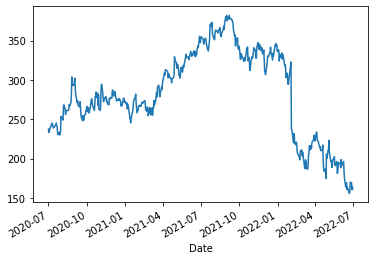

In [26]:
prelim['Adj Close'].plot()

In [27]:
prelim["Pct_change"] = prelim["Adj Close"].pct_change()
prelim.dropna(inplace = True)
prelim.head()

,Open,Adj Close,Volume,Sentiment_score,com_score,Pct_change
Date,,,,,,
2020-07-02,239.000000,233.419998,30633600,0.00000,2,-0.017386
2020-07-06,233.759995,240.279999,26206200,-0.03350,3,0.029389
2020-07-07,239.410004,240.860001,27887800,0.00000,2,0.002414
2020-07-08,238.110001,243.580002,29791300,-0.01575,3,0.011293
2020-07-09,245.000000,244.500000,22174900,0.14700,1,0.003777


In [28]:
prelim.columns

Index(['Open', 'Adj Close', 'Volume', 'Sentiment_score', 'com_score',
       'Pct_change'],
      dtype='object')

In [29]:
prelim = prelim.drop(['Open','Volume'],axis='columns')

In [30]:
prelim

,Adj Close,Sentiment_score,com_score,Pct_change
Date,,,,
2020-07-02,233.419998,0.000000,2,-0.017386
2020-07-06,240.279999,-0.033500,3,0.029389
2020-07-07,240.860001,0.000000,2,0.002414
2020-07-08,243.580002,-0.015750,3,0.011293
2020-07-09,244.500000,0.147000,1,0.003777
...,...,...,...,...
2022-06-24,170.160004,0.009000,1,0.071874
2022-06-27,169.490005,0.001579,1,-0.003937
2022-06-28,160.679993,0.025263,1,-0.051980


In [31]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_Sscore = []
    X_pct = []
    X_Cscore = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        Sscore = df.iloc[i:(i + window), feature_col_number1]
        ts_pct = df.iloc[i:(i + window), feature_col_number2]
        tw_Cscore = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_Sscore.append(Sscore)
        X_pct.append(ts_pct)
        X_Cscore.append(tw_Cscore)
        y.append(target)
        
    return np.hstack((X_Sscore,X_pct,X_Cscore)), np.array(y).reshape(-1, 1)

In [32]:
window_size = 4

feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(prelim, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)


In [33]:
y

array([[244.5     ],
       [245.070007],
       [239.      ],
       [239.729996],
       [240.279999],
       [240.929993],
       [242.029999],
       [245.419998],
       [241.75    ],
       [239.869995],
       [232.600006],
       [230.710007],
       [233.5     ],
       [230.119995],
       [233.289993],
       [234.5     ],
       [253.669998],
       [251.960007],
       [249.830002],
       [249.119995],
       [265.279999],
       [268.440002],
       [263.      ],
       [256.130005],
       [259.890015],
       [261.299988],
       [261.23999 ],
       [261.160004],
       [262.339996],
       [262.589996],
       [269.01001 ],
       [267.01001 ],
       [271.390015],
       [280.820007],
       [303.910004],
       [293.220001],
       [293.660004],
       [293.200012],
       [295.440002],
       [302.5     ],
       [291.119995],
       [282.730011],
       [271.160004],
       [273.720001],
       [268.089996],
       [266.609985],
       [266.149994],
       [272.4

In [34]:
X

array([[233.419998, 240.279999, 240.860001, ...,   3.      ,   2.      ,
          3.      ],
       [240.279999, 240.860001, 243.580002, ...,   2.      ,   3.      ,
          1.      ],
       [240.860001, 243.580002, 244.5     , ...,   3.      ,   1.      ,
          2.      ],
       ...,
       [155.850006, 158.75    , 170.160004, ...,   2.      ,   1.      ,
          1.      ],
       [158.75    , 170.160004, 169.490005, ...,   1.      ,   1.      ,
          1.      ],
       [170.160004, 169.490005, 160.679993, ...,   1.      ,   1.      ,
          2.      ]])

In [35]:
# Use 90% of the data for training and the remainder for testing
X_split = int(0.9 * len(X))
y_split = int(0.9 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [36]:
X_train.shape

(449, 12)

In [37]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

Random Forest Regressor Model

In [38]:
model = RandomForestRegressor()
model.fit(X_train, y_train.ravel())
predicted = model.predict(X_test)
#Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = prelim.index[-len(real_prices): ]) 

stocks.head()

Root Mean Squared Error: 0.12486031107297929
R-squared : 0.736888766845539


,Real,Predicted
Date,,
2022-04-20,200.419998,217.790349
2022-04-21,188.070007,200.122932
2022-04-22,184.110001,187.114271
2022-04-25,186.990005,184.772214
2022-04-26,180.949997,186.455013


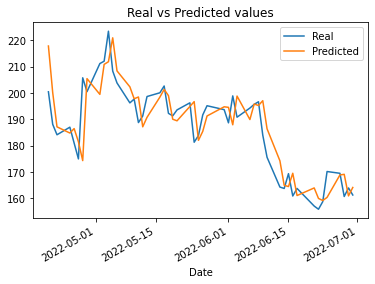

In [39]:
stocks.plot(title = "Real vs Predicted values")

XGBOOST Model

In [40]:
# Create the XG Boost regressor instance
model = XGBRegressor()
model.fit(X_train, y_train.ravel())

predicted = model.predict(X_test)

# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = prelim.index[-len(real_prices): ]) 
stocks.head()



[12:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 0.12453823849465348
R-squared : 0.7382443876907439


,Real,Predicted
Date,,
2022-04-20,200.419998,217.084625
2022-04-21,188.070007,202.412445
2022-04-22,184.110001,188.893524
2022-04-25,186.990005,184.360672
2022-04-26,180.949997,187.016449


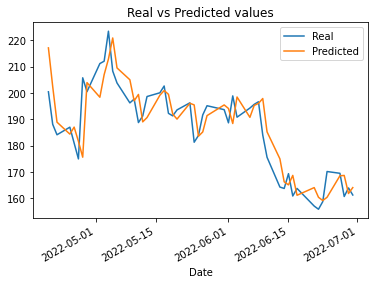

In [41]:
stocks.plot(title = "Real vs Predicted values")

Linear regression

In [42]:
model = LinearRegression()
model.fit(X_train, y_train.ravel())

predicted = model.predict(X_test)

# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = prelim.index[-len(real_prices): ]) 
stocks.head()



Root Mean Squared Error: 0.12452163940802427
R-squared : 0.7383141592658282


,Real,Predicted
Date,,
2022-04-20,200.419998,217.231648
2022-04-21,188.070007,200.833810
2022-04-22,184.110001,187.097157
2022-04-25,186.990005,184.471166
2022-04-26,180.949997,187.484352


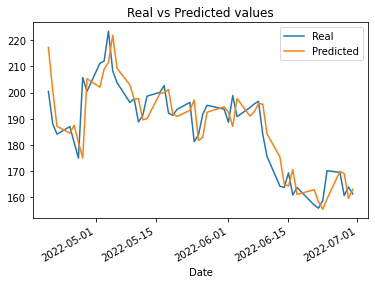

In [43]:
stocks.plot(title = "Real vs Predicted values")

Deep Learning Model

LSTM RNN model

In [44]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    
model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [46]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 9)             396       
                                                                 
 dropout (Dropout)           (None, 12, 9)             0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 9)             684       
                                                                 
 dropout_1 (Dropout)         (None, 12, 9)             0         
                                                                 
 lstm_2 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_2 (Dropout)         (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [48]:
history = model.fit(X_train, y_train, epochs=25, shuffle=False, batch_size=8, verbose=1)

Epoch 1/25
57/57 [==============================] - 10s 8ms/step - loss: 0.0794
Epoch 2/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0858
Epoch 3/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 4/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0687
Epoch 5/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0641
Epoch 6/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0541
Epoch 7/25
57/57 [==============================] - 0s 8ms/step - loss: 0.0438
Epoch 8/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0311
Epoch 9/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 10/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 11/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 12/25
57/57 [==============================] - 0s 7ms/step - loss: 0.0220
Epoch 13/25
57/57 [=============================

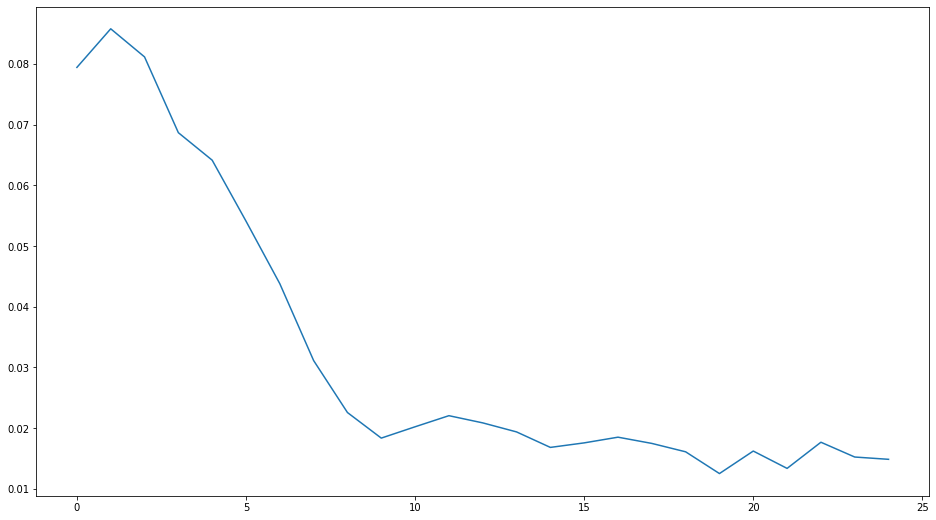

In [49]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])

In [50]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = prelim.index[-len(real_prices): ]) 
stocks.head()

2/2 [==============================] - 1s 12ms/step
Root Mean Squared Error: 0.1530620991216355
R-squared : 0.6046098053688124


,Real,Predicted
Date,,
2022-04-20,200.419998,204.616928
2022-04-21,188.070007,203.235001
2022-04-22,184.110001,201.507187
2022-04-25,186.990005,197.820145
2022-04-26,180.949997,191.673935


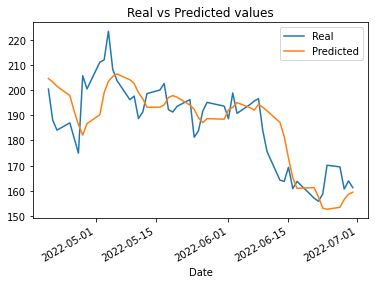

In [51]:
stocks.plot(title = "Real vs Predicted values")

BiLSTM

In [52]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=(X_train.shape[1], 1)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=1),
 ])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 12, 400)          323200    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 12, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 20)                6020      
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [53]:
history = model.fit(X_train, y_train, epochs=25, shuffle=False, batch_size=32, verbose=1)

Epoch 1/25
15/15 [==============================] - 5s 12ms/step - loss: 0.0851
Epoch 2/25
15/15 [==============================] - 0s 10ms/step - loss: 0.1495
Epoch 3/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0723
Epoch 4/25
15/15 [==============================] - 0s 11ms/step - loss: 0.0898
Epoch 5/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0467
Epoch 6/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0388
Epoch 7/25
15/15 [==============================] - 0s 11ms/step - loss: 0.0250
Epoch 8/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 9/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0155
Epoch 10/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 11/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0116
Epoch 12/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 13/25
15/15 [==================

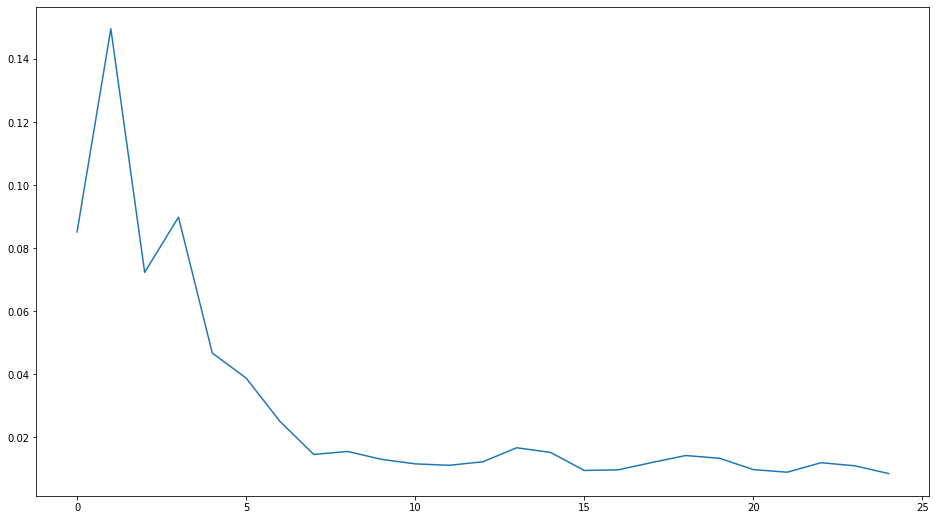

In [54]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])

In [55]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = prelim.index[-len(real_prices): ]) 
stocks.head()

2/2 [==============================] - 1s 9ms/step
Root Mean Squared Error: 0.1633065390553847
R-squared : 0.5499117092144672


,Real,Predicted
Date,,
2022-04-20,200.419998,210.726364
2022-04-21,188.070007,208.365189
2022-04-22,184.110001,204.687164
2022-04-25,186.990005,199.095795
2022-04-26,180.949997,189.528488


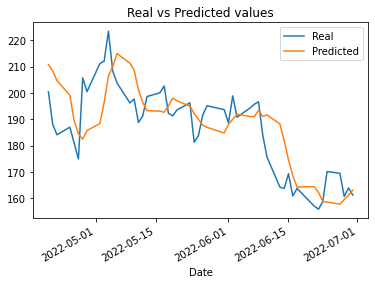

In [56]:
stocks.plot(title = "Real vs Predicted values")